In [15]:
import nltk
from nltk.corpus import brown, gutenberg, shakespeare, wordnet, reuters
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
wordnet_lemmatizer = WordNetLemmatizer()
from xml.etree import ElementTree

# Import lexicon
from nltk.corpus import words
lex = words.words('en')

import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline
import numpy as np

In [16]:
# Prefixes of interest
prefixes_pattern = "un|non|dis|in"
prefixes = ["un", "non", "dis", "in"]

# Function to replace treebank tag with a wordnet tag to use with the Lemmatizer
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # Unfortunately, wordnet only supports adjective, verb, noun and adverb parts of speech
        # So, any word whose POS is not covered by wordnet will default to NOUN
        return wordnet.NOUN

def process_shakespeare(shakespeare):
    plays = shakespeare.fileids() # doctest: +ELLIPSIS
    shk_words = []
    for play in plays:
        lines = [str(line.text) for line in shakespeare.xml(play).findall('ACT/SCENE/SPEECH/LINE')]
        for l in lines:
            shk_words += word_tokenize(l)
    return shk_words

In [17]:
def tuplize(matched_word):  
    word = matched_word[0]
    tag = matched_word[1]
    # Separate prefix from stem
    prefix = re.match(prefixes_pattern, word).group(0)
    stem = re.sub(prefix, '', word, count=1)
    lem_stem = wordnet_lemmatizer.lemmatize(stem, pos=(get_wordnet_pos(tag)))
    return (word, tag, prefix, stem, lem_stem)

def find_affixes(corpus_words):
    # Get all tokens that have prefixes of interest
    pattern = r'\bun\w+|\bnon\w+|\bdis\w+|\bin\w+'
    prefixed_words = list(set([w for w in corpus_words if re.match(pattern, w) and len(w) > 3]))
    
    # Tag words
    # Words_tagged is a list of tuples containing (word, tag)
    words_tagged = nltk.pos_tag(prefixed_words)
    
    # (word, pos_tag, prefix, stem, lemmatized_stem)
    # e.g. (disproportionate, JJ, dis, proportionate, )
    words_of_interest = [tuplize(w) for w in words_tagged]

    # Get rid of erroneous words of interest
    # Check if stem is in the lexicon
    # If so, the prefix is negating and keep the word
    # If not, discard the word
    filtered = [w for w in words_of_interest if w[4] in lex]
    
    return filtered

In [18]:
def get_filtered_words(filtered):
    return [f[0] for f in filtered]

In [19]:
# Token frequency: Number of actual words formed according to a certain pattern over the corpus
def token_frequency(words, corpus_words):
    token_freqs = dict(zip(prefixes, ([0]*len(prefixes))))
    for c in corpus_words:
        if c in words:
            # Compute frequencies
            prefix = re.match(prefixes_pattern, c).group(0)
            token_freqs[prefix] += 1
    return token_freqs
            
def type_frequency(filtered):
    type_freqs = dict(zip(prefixes, ([0]*len(prefixes))))
    for f in filtered:
        # Compute frequencies
        prefix = re.match(prefixes_pattern, f).group(0)
        type_freqs[prefix] += 1
    return type_freqs

def pie_chart(freqs):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [pf.capitalize() + "-" for pf in freqs]
    sizes = [freqs[pf] for pf in freqs]
    explode = (0, 0, 0, 0)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
def analyze(corpus_words, filtered_words):
    corpus_size = len(corpus_words)
    filtered_size = len(filtered_words)
    prefix_tk_freqs = token_frequency(filtered_words, corpus_words)
    prefix_ty_freqs = type_frequency(filtered_words)

    for pf in prefixes:
        prefix_tk_freqs[pf] /= corpus_size

    for pf in prefixes:
        prefix_ty_freqs[pf] /= filtered_size

    for pf in prefixes:
        print("Token frequency of {} = {}".format(pf, prefix_tk_freqs[pf]*100))
    print()    
    for pf in prefixes:
        print("Type frequency of {} = {}".format(pf, prefix_ty_freqs[pf]*100))

    pie_chart(prefix_ty_freqs)

Token frequency of un = 0.20125870657048966
Token frequency of non = 0.01687920688396062
Token frequency of dis = 0.1262495780198279
Token frequency of in = 0.47313450316571243

Type frequency of un = 41.10479285134037
Type frequency of non = 4.1429731925264015
Type frequency of dis = 21.364744110479286
Type frequency of in = 33.38748984565394


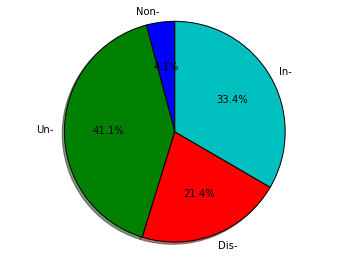

Token frequency of un = 0.48374798263511815
Token frequency of non = 0.02673926319407174
Token frequency of dis = 0.07873015582391452
Token frequency of in = 0.34177431985575296

Type frequency of un = 51.103896103896105
Type frequency of non = 0.45454545454545453
Type frequency of dis = 18.896103896103895
Type frequency of in = 29.545454545454547


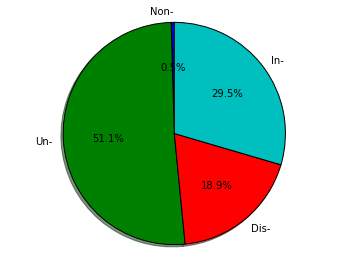

Token frequency of un = 0.16437647754137116
Token frequency of non = 0.0383237293144208
Token frequency of dis = 0.11220079787234044
Token frequency of in = 0.18746306146572106

Type frequency of un = 48.96907216494845
Type frequency of non = 0.5154639175257731
Type frequency of dis = 22.938144329896907
Type frequency of in = 27.577319587628867


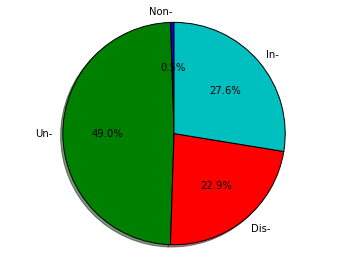

Token frequency of un = 0.1817071406199427
Token frequency of non = 0.004997382185262255
Token frequency of dis = 0.10116793470397194
Token frequency of in = 0.3739320274670071

Type frequency of un = 34.904013961605585
Type frequency of non = 5.7591623036649215
Type frequency of dis = 25.654450261780106
Type frequency of in = 33.682373472949386


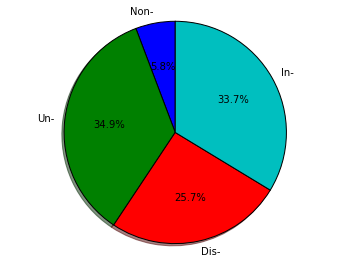

In [20]:
# Step 4: Analysis
corpora_words = [brown.words(), gutenberg.words(), process_shakespeare(shakespeare), reuters.words()]

for cw in corpora_words:
    words_filtered = get_filtered_words(find_affixes(cw))
    analyze(cw, words_filtered)

In [21]:
def stacked_bar_graph(cats, freqs):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(20,15))

    # Set the bar width
    bar_width = 0.75

    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(len(cats))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    tick_pos = [i+(bar_width/2) for i in bar_l]
    
    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['in'] for cat in cats],
            # set the width
            width=bar_width,
            # with the label pre score
            label='in',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='b')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['dis'] for cat in cats],
            # set the width
            width=bar_width,
            bottom=[freqs[cat]['in'] for cat in cats],
            # with the label pre score
            label='dis',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='g')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['non'] for cat in cats],
            # set the width
            width=bar_width,
            # with the label pre score
            bottom=[i+j for i,j in zip([freqs[cat]['in'] for cat in cats],[freqs[cat]['dis'] for cat in cats])],
            label='non',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='y')
    
    ax1.bar(bar_l,
            # using frequency
            [freqs[cat]['un'] for cat in cats],
            # set the width
            width=bar_width,
            bottom=[i+j+k for i,j,k in zip([freqs[cat]['in'] for cat in cats],[freqs[cat]['dis'] for cat in cats],
                                        [freqs[cat]['non'] for cat in cats])],
            # with the label pre score
            label='un',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='r')

    # set the x ticks with names
    plt.xticks(tick_pos, cats)

    # Set the label and legends
    ax1.set_ylabel("Type frequency")
    ax1.set_xlabel("Categories")
    plt.legend(loc='upper left')

    # Set a buffer around the edge
    plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

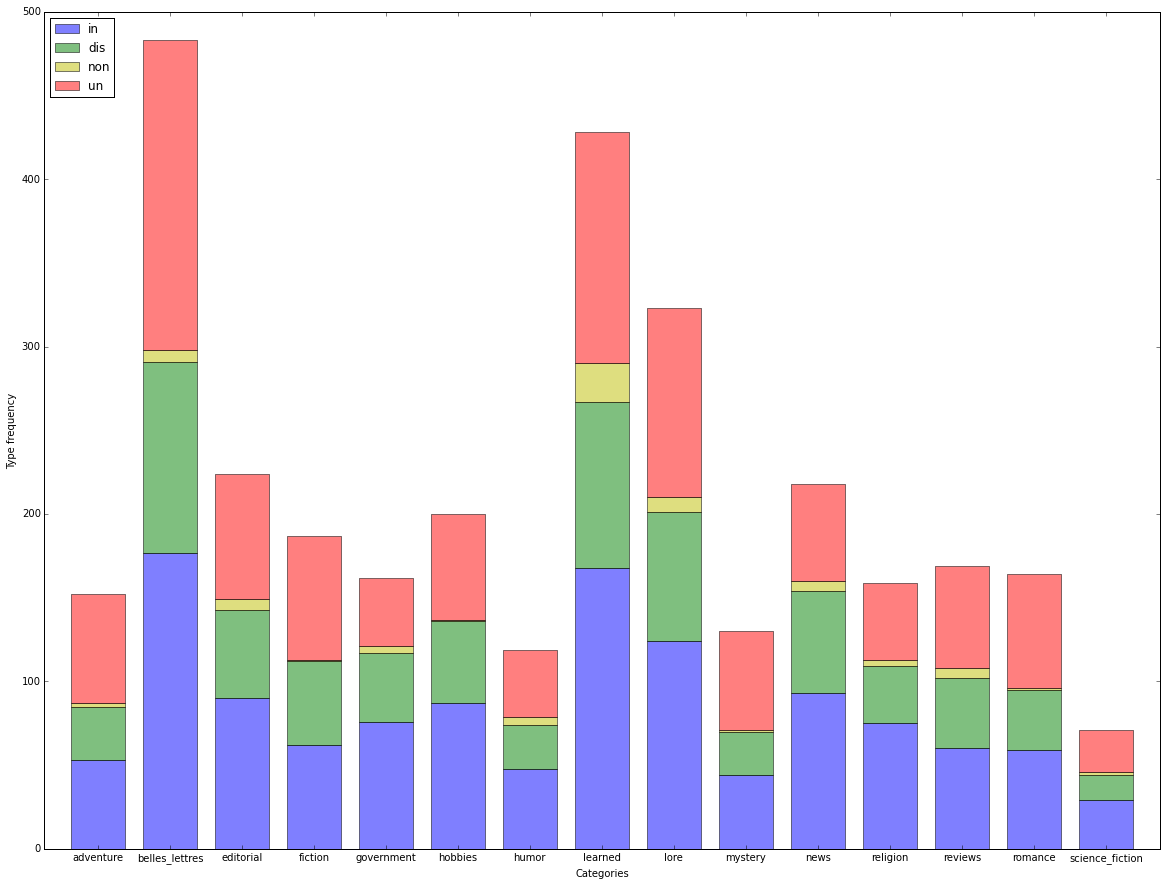

In [22]:
brown_cat_ty_freqs = dict(zip(brown.categories(), {}))

for cat in brown.categories():
    brown_ty_freqs = type_frequency(get_filtered_words(find_affixes(brown.words(categories=cat))))  
    brown_cat_ty_freqs[cat] = brown_ty_freqs
    
stacked_bar_graph(brown.categories(), brown_cat_ty_freqs)

In [23]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [24]:
def gutenberg_cats(cat):
    if cat == 'religion':
        return ["bible-kjv.txt"]
    elif cat == 'poem':
        return ["blake-poems.txt", "milton-paradise.txt", "whitman-leaves.txt"]
    elif cat == 'play':
        return ['shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt']
    else:
        return ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bryant-stories.txt', 
         'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 
         'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt']

def words_by_cat(corpus, cat):
    if corpus == gutenberg:
        gt_words = []
        for f in gutenberg_cats(cat):
            gt_words += word_tokenize(gutenberg.raw(f))
        return gt_words
    elif corpus == brown:
        return brown.words(categories=cat)

In [25]:
all_categories = brown.categories() + ['play', 'poem']
pf_freqs = dict(zip(prefixes, [0]*len(prefixes)))
ty_freqs = dict(zip(all_categories, [pf_freqs]*len(all_categories)))
    
brown_ty_fqs = dict(zip(brown.categories(), [pf_freqs]*len(brown.categories())))
for cat in brown.categories():
    ty_freqs[cat] = type_frequency(get_filtered_words(find_affixes(words_by_cat(brown, cat))))
        
gut_cats = ['fiction', 'religion', 'poem', 'play']
gtbg_ty_freqs = dict(zip(gut_cats, [pf_freqs]*len(gut_cats)))
for cat in gut_cats:
    gtbg_ty_freqs[cat] = type_frequency(get_filtered_words(find_affixes(words_by_cat(gutenberg, cat))))
    for pf in gtbg_ty_freqs[cat]:
        ty_freqs[cat][pf] += gtbg_ty_freqs[cat][pf]

ty_freqs['play'] = type_frequency(get_filtered_words(find_affixes(process_shakespeare(shakespeare))))
                         
ty_freqs['news'] = type_frequency(get_filtered_words(find_affixes(reuters.words())))

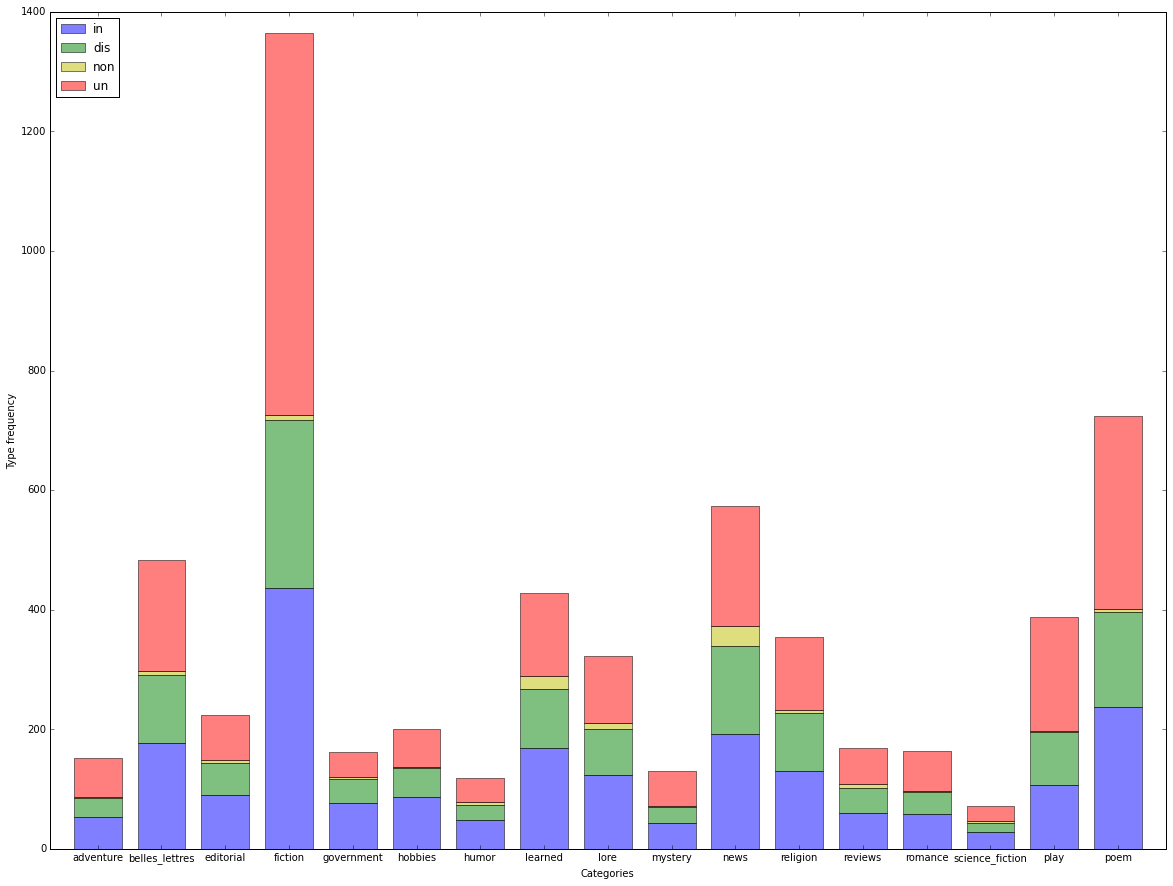

In [26]:
stacked_bar_graph(all_categories, ty_freqs)

In [41]:
for corpus in corpora_words:
    print(len(corpus))

1161192
2621613
216576
1720901


In [44]:
corpora_words = [brown.words(), gutenberg.words(), process_shakespeare(shakespeare), reuters.words()]

for cw in corpora_words:
    words_filtered = get_filtered_words(find_affixes(cw))

for w in words_filtered:
    print(w)

unspectacular
internal
uninsured
uncovered
unsympathetic
nonoperating
displays
unequal
intractable
unquantifiable
discriminatory
unfinished
nonstop
disaster
invests
infighting
insecure
uncommon
unable
unethical
discount
nonvoting
unrepresentative
unsmoothed
nondurable
unleaded
insist
disequilibrium
uneven
insolvencies
disc
independence
unwarranted
unrealistic
uncouple
dismantle
inexpensively
unused
unprecedented
displaced
unfavorable
unaffected
distaste
insolvency
unalloyed
unmatched
disadvantages
nonsensical
inappropriateness
distract
undisguised
unstable
unseat
inundated
unwinding
investments
unfolding
insures
inapplicable
injunction
indigenous
unreservedly
discontinuance
unrevised
inaccessible
intransigence
unsold
unclear
infancy
discs
increasing
incalculable
unduly
indecisive
ingot
disposing
informal
informations
unposted
disgorge
unveiled
discuss
unsafe
dismantles
unreserved
inactive
unrestricted
inward
nonearning
undivided
unions
distortive
unsettle
disregard
dissatisfied
discret

In [42]:
from collections import defaultdict
lemma = defaultdict(set)
for t in find_affixes(gutenberg.words()):
    word = t[0]
    tag = t[1]
    prefix = t[2]
    stem = t[3]
    lem_stem = t[4]
    lemma[lem_stem].add(word)

for l in lemma:
    if len(lemma[l]) > 1:
        print('{} = {}'.format(l, lemma[l]))

tense = {'intense', 'intensest'}
aster = {'disasters', 'disaster'}
hale = {'inhale', 'inhaling'}
expert = {'inexpert', 'unexpert'}
tend = {'distend', 'intend', 'intended', 'untended', 'intends'}
let = {'inlets', 'inlet'}
please = {'displeased', 'displeases', 'displease', 'unpleasing'}
treaty = {'intreaties', 'intreaty'}
ion = {'inions', 'union'}
solve = {'dissolved', 'dissolving', 'dissolve'}
card = {'discarded', 'discard'}
claim = {'disclaimed', 'disclaiming', 'unclaim', 'disclaims'}
connect = {'disconnect', 'disconnected'}
exaggerate = {'unexaggerated', 'unexaggerating'}
ward = {'inward', 'inwards'}
stall = {'installed', 'install'}
fidelity = {'infidelities', 'infidelity'}
vocation = {'invocations', 'invocation'}
fit = {'unfit', 'unfitted'}
able = {'disable', 'unable'}
regard = {'disregards', 'disregard', 'disregarding'}
believer = {'unbelievers', 'disbelievers'}
guise = {'disguises', 'disguise'}
agree = {'disagreed', 'disagree', 'disagreeing'}
position = {'disposition', 'disposition